<center>
    <h1> INF510 - Advanced Computational Methods  </h1>
    <h2> Test #2 - Spectral Methods  </h2> 
</center>

* Martín Villanueva - `martin.villanueva@usm.cl` - **rol:** 201104012-0

_DI UTFSM. 2018._

In [1]:
%matplotlib inline

import numpy as np
from numpy.fft import fft,ifft
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import interact, fixed
from ipywidgets import IntSlider, FloatSlider

### Helper functions

In [35]:
def cheb(N):
    if N==0:
        D=0.
        x=1.
        return D,x
    x = np.cos(np.pi*np.arange(N+1)/N)
    c=np.hstack((2,np.ones(N-1),2))*((-1.)**np.arange(N+1))
    X=np.tile(x,(N+1,1)).T
    dX=X-X.T
    D = np.outer(c,1./c)/(dX+np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    return D,x

def surface_plot(xx, yy, vv, time=None):  
    fig = plt.figure(figsize=(13,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, vv, linewidth=0.0, rstride=1, cstride=1, cmap='jet')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('v')
    ax.view_init(elev=40., azim=300.)
    if time is not None:
        plt.title('Solution at t={0}'.format(time))
    plt.show()

def surface_plot_helper(xx, yy, usol, time, index):
    vv = usol[index]
    t = time[index]
    surface_plot(xx, yy, vv, time=t)
    
def lines_plot(xgrid, tgrid, U, xlim=None, tlim=None, ulim=None, title=None, numli=20.):
    udata = list()
    tdata = list()
    
    delta = int(U.shape[0]/float(numli))
    for i in range(U.shape[0]):
        if i%delta != 0: continue
        tdata.append(tgrid[i])
        udata.append( zip(xgrid, U[i]) )

    fig = plt.figure(figsize=(12,6))
    ax = fig.gca(projection='3d')
    lc = LineCollection(udata)
    lc.set_alpha(0.5)
    ax.add_collection3d(lc, zs=tdata, zdir='y')
    ax.set_xlabel('x')
    ax.set_xlim3d(xlim)
    ax.set_ylabel('t')
    ax.set_ylim3d(tlim)
    ax.set_zlabel('u')
    ax.set_zlim3d(ulim)
    ax.view_init(elev=45., azim=245)
    plt.title(title)
    plt.show()

### Problem `#1`

To address the problem in a more general way, we rewrite the equation as a __Lyapunov equation__: $AX+XA^T=B$, where $A = \widetilde{D}_{N}^{2}$ and $B=f(X,Y)$.

We already know how to solve this matrix equation through the \textit{Kronecker product trick}, which translates the problem to a linear system of equations of the form:

$$
\underbrace{(I \otimes A) + (A \otimes I)}_{\mathbf{L}} \ \text{vec}(X) = \text{vec}(B).
$$

The aim of this problem is to build a solution of the Lyapunov equation without building $\mathbf{L}$ and based on GMRES. 

However, in first place we implement a function to solve the problem through the mentioned method:

In [259]:
# example matrices
np.random.seed(0)
A = np.random.random((4,4))
B = np.random.random((4,4))

In [42]:
def lyapunov_solver1(A,B):
    n = A.shape[0]
    I = np.identity(n)
    L = np.kron(I,A)+np.kron(A,I)
    b = np.ravel(B, order='F')
    x = np.linalg.solve(L, b)
    return np.reshape(x, (n,n), order='F')

In [43]:
lyapunov_solver1(A,B)

array([[  1.13415557,  -3.71098593,  -2.52040733,   6.16299329],
       [ -0.71908815,   7.56716845,   6.22961297, -13.2807577 ],
       [  1.35674164, -18.6424307 ,  -4.86801527,  26.50387982],
       [ -1.30856646,  11.41087814,  -0.53920726, -12.03367195]])

In [ ]:
def arnoldi_iteration(A,V,m):
    VV = [V]
    H = np.zeros((m+1,m))
    for i in range(m):
        W = np.dot(A,V[i])
        for j in range(i+1):
            H[i,j] = np.trace(np.dot(V[i].T, W))
            W -= H[i,j]*V[i]
        H[i+1,i] = np.linalg.norm(W, ord='fro')
        if H[i+1,i]==0: break
        V.append(W/H[i+1,i])
    return VV,H

def lyapunov_solver2(A,V,m):
    pass   

### Problem `#2`

In this problem we are encouraged to solve the wave equation in two space dimensions:

$$
u_{tt} = u_{xx} + u_{yy}, \ \ \ \ \ -1<x,y<1, \ \ t>0 \ \ u = 0 \ \text{on the boundary},
$$

with initial conditions: $u(x,y,0) = e^{-40\left( (x-0.4)^2 + y^2 \right)}$ and $u_t(x,y,0) = 0$. We are asked to solve numerically this problem with two methods: With _Fourier method_ emulating the `Program 20` implementation from the guide book, and with _Chebyshev method_ implementing it with optimized matrix operations.

As usual, to solve this PDE we use spectral differentation in space and finite differences in time. For the second case, we use Chebyshev differentiation matrices to numerically approxite $u_{xx}+u_{yy}$ as follows:

$$u_{xx} \approx D_N^2 U \ \ \ \text{and} \ \ \ u_{yy} \approx U (D_N^2)^T$$

where $U$ is the matrix obtained when $u(x,y)$ is evaluated in the regular $xy$-grid. Below is the corresponding implementation which takes `N`, and solve this problem with the Chebyshev method in a grid of size `(N+1)x(N+1)`.

In [3]:
# Chebyshev method solver
def wave_equation_solver1(N):
    D,x = cheb(N); y = np.copy(x)
    D2 = np.dot(D,D)
    xx,yy = np.meshgrid(x,y)

    # initial condition
    uu = np.exp(-40*((xx-0.4)**2 + yy**2))
    uuold = uu

    # boundary conditions
    uu[0,:]=0; uu[-1,:]=0; uu[:,0]=0; uu[:,-1]=0

    # time stepping with leap-frog formula
    t = 1.0
    dt = (5.0)/(N**2)
    n_iter = int(t/dt)
    usol = np.zeros((n_iter,len(x),len(y)))
    usol[0,:,:] = uu
    
    for i in range(1,n_iter):
        uxx = np.dot(D2,uu)
        uyy = np.dot(uu,D2.T)
        uunew = 2*uu - uuold + (dt**2)*(uxx+uyy)
        # enforcing boundary conditions
        uunew[0,:]=0; uunew[-1,:]=0; uunew[:,0]=0; uunew[:,-1]=0
        uuold = uu
        uu = uunew
        usol[i,:,:] = uu
    
    return xx,yy,usol

In the cell below is presented the Python port to the Matlab code in `Program 20` of the guide book, which is based in the code available below in the question's reference.

In [26]:
# Fourier method solver
def wave_equation_solver2(N):
    x = np.cos(np.pi*np.arange(0,N+1)/N) 
    y = np.copy(x)    
    xx, yy = np.meshgrid(x,y)

    # initial condition
    vv = np.exp(-40*((xx-0.4)**2 + yy**2));
    vvold = vv

    # time stepping with leap-frog formula
    t = 1.0
    dt = (5.0)/(N**2)
    n_iter = int(t/dt)
    usol = np.zeros((n_iter,len(x),len(y)))
    usol[0,:,:] = vv

    for k in range(1,n_iter):
        uxx = np.zeros((N+1,N+1)); uyy = np.zeros((N+1,N+1));
        ii = np.arange(1,N);

        for i in range(1,N):
            v = vv[i,:];          
            V = list(v) + list(np.flipud(v[ii]));
            U = np.real(np.fft.fft(V));
            w1_hat = 1j*np.zeros(2*N);
            w1_hat[0:N] = 1j*np.arange(0,N)
            w1_hat[N+1:] = 1j*np.arange(-N+1,0)
            W1 = np.real(np.fft.ifft(w1_hat * U))
            w2_hat = 1j*np.zeros(2*N);
            w2_hat[0:N+1] = np.arange(0,N+1)
            w2_hat[N+1:] = np.arange(-N+1,0)
            W2 = np.real(np.fft.ifft((-w2_hat**2) * U))
            uxx[i,ii] = W2[ii]/(1-x[ii]**2) - (x[ii]*W1[ii])/(1-x[ii]**2)**(3.0/2);
        for j in range(1,N):
            v = vv[:,j]; 
            V = list(v) + list(np.flipud(v[ii]));
            U = np.real(np.fft.fft(V))
            w1_hat = 1j*np.zeros(2*N);
            w1_hat[0:N] = 1j*np.arange(0,N)
            w1_hat[N+1:] = 1j*np.arange(-N+1,0)
            W1 = np.real(np.fft.ifft(w1_hat * U))
            w2_hat = 1j*np.zeros(2*N);
            w2_hat[0:N+1] = np.arange(0,N+1)
            w2_hat[N+1:] = np.arange(-N+1,0)
            W2 = np.real(np.fft.ifft(-(w2_hat**2) * U))
            uyy[ii,j] = W2[ii]/(1-y[ii]**2) - y[ii]*W1[ii]/(1-y[ii]**2)**(3.0/2.0);
        vvnew = 2*vv - vvold + dt**2 *(uxx+uyy)
        vvold = vv
        vv = vvnew
        usol[k,:,:] = vv
    return xx,yy,usol

To make fair comparisons we use the same time-step and ODE solver (leap frog) in both methods, for time $0\leq t \leq 1$.

#### Time benchmarks

Below we present time bechmarks for both implementations (Chebyshev and Fourier, respectively) for different grid sizes, $N=24,48,96,192$.

In [40]:
# Chebyshev method benchmarks
t1 = %timeit -o wave_equation_solver1(24)
t2 = %timeit -o wave_equation_solver1(48)
t3 = %timeit -o wave_equation_solver1(96)
t4 = %timeit -o wave_equation_solver1(192)
chebyshev_times = [t1.best, t2.best, t3.best, t4.best]

100 loops, best of 3: 3.58 ms per loop
10 loops, best of 3: 33.4 ms per loop
1 loop, best of 3: 510 ms per loop
1 loop, best of 3: 9.52 s per loop


In [41]:
# Fourier method benchmarks
t1 = %timeit -o wave_equation_solver2(24)
t2 = %timeit -o wave_equation_solver2(48)
t3 = %timeit -o wave_equation_solver2(96)
t4 = %timeit -o wave_equation_solver2(192)
fourier_times = [t1.best, t2.best, t3.best, t4.best]

1 loop, best of 3: 1.02 s per loop
1 loop, best of 3: 9.66 s per loop
1 loop, best of 3: 1min 24s per loop
1 loop, best of 3: 13min 57s per loop


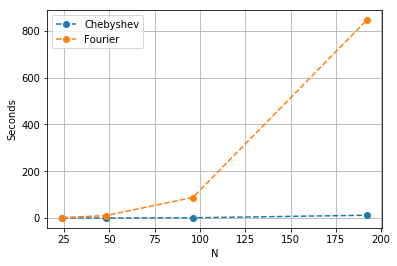

In [91]:
plt.plot([24,48,96,192], chebyshev_times, "o--", label="Chebyshev")
plt.plot([24,48,96,192], fourier_times, "o--", label="Fourier")
plt.grid()
plt.xlabel("N")
plt.ylabel("Seconds")
plt.legend(loc="best")
plt.show()

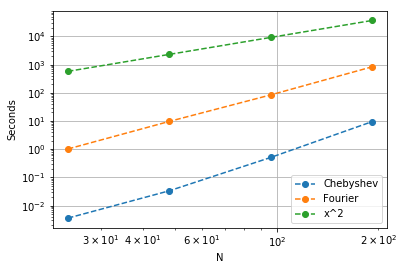

In [72]:
plt.loglog([24,48,96,192], chebyshev_times, "o--", label="Chebyshev")
plt.loglog([24,48,96,192], fourier_times, "o--", label="Fourier")
plt.loglog([24,48,96,192], [24**2,48**2,96**2,192**2], "o--", label="x^2")
plt.grid()
plt.xlabel("N")
plt.ylabel("Seconds")
plt.legend(loc="best")
plt.show()

It is clearly seen that the Chebyshev method is much more faster than the Fouier's one. It important to note from the `loglog` plot that even when Chebyshev method requieres less time than the Fourier's one, it has a slightly steeper slope. This happens because Chebyshev is $O(N^2)$, while Fourier is $O(N \log N)$. 

#### Outputs comparison

Below we show the output comparisons for both methods with $N=96$ in a interactive widget, so it is possible to compare the outputs at the same times. As you can see, there are no appreciable differences between both solutions.

In [25]:
xx1,yy1,usol1 = wave_equation_solver1(96)
xx2,yy2,usol2 = wave_equation_solver2(96)
time = np.linspace(0., 1., usol1.shape[0])

In [36]:
# Chebyshev solution
interact(surface_plot_helper, xx=fixed(xx1), yy=fixed(yy1), usol=fixed(usol1), 
         time=fixed(time), index=IntSlider(min=0,max=1842,step=10,value=0));

interactive(children=(IntSlider(value=0, description=u'index', max=1842, step=10), Output()), _dom_classes=('widget-interact',))

In [37]:
# Fourier solution
interact(surface_plot_helper, xx=fixed(xx2), yy=fixed(yy2), usol=fixed(usol2), 
         time=fixed(time), index=IntSlider(min=0,max=1842,step=10,value=0));

interactive(children=(IntSlider(value=0, description=u'index', max=1842, step=10), Output()), _dom_classes=('widget-interact',))

#### References for Question `#2`
* http://nbviewer.jupyter.org/github/cpraveen/chebpy/blob/master/p20.ipynb

### Problem `#3`

Then we need to solve the following IVP in the fourier domain:

$$
\widehat{U}_t = - ik e^{-\epsilon(ik)^2t} \widehat{u}^2 
$$

$$
\widehat{U}_t = -ik e^{-\epsilon(ik)^2t}  \mathcal{F}\left( \mathcal{F}^{-1}( e^{\epsilon (ik)^2 t} \widehat{U}) \right)^2 
$$

In [110]:
# epsilon value
eps = 0.25

# number of grid points
N = 256

# x-grid
xgrid = np.linspace(-np.pi, np.pi, N)

# initial conditions
u0 = np.zeros(N)
u0[0:N/2] = np.sin(xgrid[0:N/2])**2 
v = np.fft.fft(u0)

# wave numbers
k = np.concatenate((np.arange(0,N/2), np.array([0]), np.arange(-N/2+1,0,1)))
ik = (1j*k) 
ik2 = (1j*k)**2

# ode solver parameters
t = 0.
dt = .01/N**2
tmax = 0.1
n_iter = int(round(tmax/dt))
time_grid = np.linspace(0., tmax, n_iter+1)

# solution array
U = np.empty((n_iter+1, len(u0)))
U[0] = u0

In [111]:
# Solution with Euler's method
for i in range(1, n_iter+1):
    t += dt
    vt = -ik * np.exp(-eps*ik2*t) * fft(np.real( ifft(np.exp(eps*ik2*t)*v))**2)
    v += vt*dt
    U[i] = np.real( np.fft.ifft(v) ) 

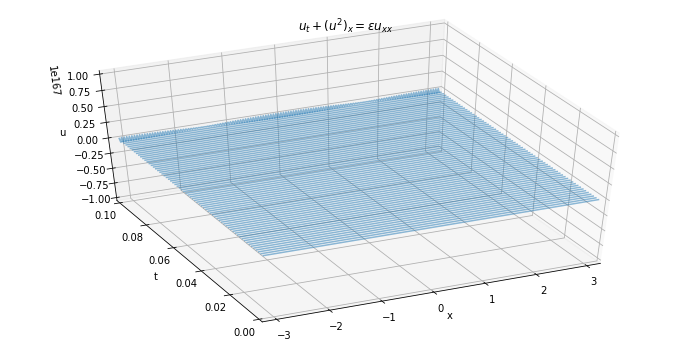

In [115]:
lines_plot(xgrid, time_grid, U, tjump=10000, 
           xlim=(-np.pi, np.pi), tlim=(0,tmax), 
           ulim=(U.min()-0.05,U.max()+0.05),
          title='$u_t + (u^2)_x = \epsilon u_{xx}$')

***
***

The equation we want to solve corresponds to the _Burgers equation_ which takes the form:

$$
u_t + (u^2)_{x} = \epsilon u_{xx} \ \ \ \ \ \text{with IC: } \ \ u(x,0) = \begin{cases} \sin^2(x)  \ \ \ x \in [-\pi,0] \\ 0 \ \ \ \ \ \ \ \ \ \ \ \  x \in \ (0,\pi] \end{cases}
$$

which mmodels the ...


We follow the approach of integrating factors, by first applying the fourier transform in the spatial domain with the aim of obtaining a more tratable problem in the :

\begin{align}
\widehat{u_t} + i k \widehat{u^2} - \epsilon (ik)^2 \widehat{u} &= 0 \ \ \ \ \ / \cdot e^{-\epsilon (ik)^2 t} \\
\widehat{u_t} e^{-\epsilon (ik)^2 t} + i k \widehat{u^2} e^{-\epsilon (ik)^2 t} - \epsilon (ik)^2 \widehat{u} e^{-\epsilon (ik)^2 t} &= 0
\end{align}

Now, if we define $\widehat{U} = e^{-\epsilon(ik)^2 t} \widehat{u}$ and notice that deriving it respect to time gives: $\widehat{U}_t = -\epsilon (ik)^2 \widehat{U} + e^{-\epsilon(ik)^2 t} \widehat{u}_t$, we can replace it in the previous equation obtaining:

\begin{align}
\widehat{U}_t + ik e^{-\epsilon (ik)^2 t} \widehat{u^2} &= 0 \\
\widehat{U}_t &= - ik e^{-\epsilon (ik)^2 t} \widehat{u^2} \\
\widehat{U}_t &= - ik e^{-\epsilon (ik)^2 t} \mathcal{F}\left( \mathcal{F}^{-1}\left(e^{\epsilon (ik)^2 t} \widehat{U}\right)^2 \right)
\end{align}

The last equation is much more simple (is an ODE) and the influence of the linear term (the one with high frequency) is gone. The procedure now consists of solving the ODE in the _fourier space_ (frequency domain) with a numerical integration method. The algorithm works as follows:

1. Map the initial condition to the Fourier space with the corresponding integrating factor: $\widehat{U_0} = e^{-\epsilon (ik)^2 t} \widehat{u_0}$.
2. Run an ODE solver over $\widehat{U}_t = - ik e^{-\epsilon (ik)^2 t} \widehat{u^2}$.
3. The get the solution in the original space compute the inverse Fourier transform of $\widehat{U}_{\text{final}}$: $\ \ \ \ u = \mathcal{F}^{-1}(e^{ik^3 t} \widehat{U})$.

In [5]:
def burgers_equation_solver(N, eps):
    # x-grid
    xgrid = np.linspace(-np.pi, np.pi, N)
    # initial conditions
    u0 = np.zeros(N)
    u0[0:N//2] = np.sin(xgrid[0:N//2])**2 
    v = np.fft.fft(u0)
    # wave numbers
    k = np.concatenate((np.arange(0,N/2), np.array([0]), np.arange(-N/2+1,0,1)))

    # ode solver parameters
    dt = 0.1
    t = 0.
    tmax = 3.
    n_iter = int(round(tmax/dt))
    time_grid = np.linspace(0., tmax, n_iter+1)

    # solution array
    U = np.empty((n_iter+1, len(u0)))
    U[0] = u0
    
    ik2 = (1j*k)**2
    E = np.exp(eps*ik2*dt/2); E2 = E**2
    g = -1j*k*dt
    
    # solution with RK4's method
    for i in range(1, n_iter+1):
        k1 = g * np.fft.fft( np.real( np.fft.ifft( v ) )**2 )
        k2 = g * np.fft.fft( np.real( np.fft.ifft( E*(v + k1/2) ) )**2 )
        k3 = g * np.fft.fft( np.real( np.fft.ifft( E*v + k2/2 ) )**2 )
        k4 = g * np.fft.fft( np.real( np.fft.ifft( E2*v + E*k3 ) )**2 )
        v = E2*v + (E2*k1 + 2*E*(k2+k3) + k4)/6
        # we just store the solution at the original (spatial) domain
        U[i] = np.real( np.fft.ifft(v) )
    return xgrid,time_grid,U

#### Solution for `N=64`

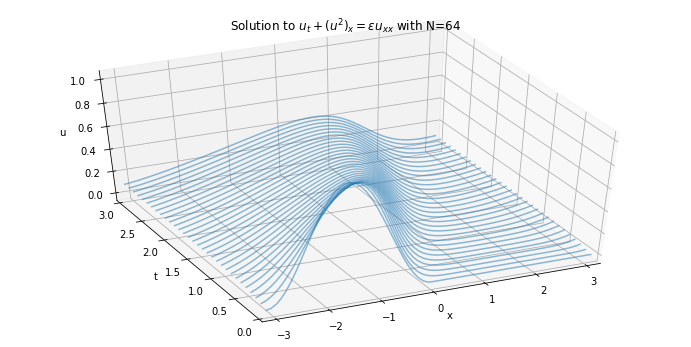

In [6]:
xgrid1,time_grid1,U1 = burgers_equation_solver(64, 0.25)
lines_plot(xgrid1, time_grid1, U1, 
           xlim=(-np.pi, np.pi), tlim=(0,3), 
           ulim=(U1.min()-0.05,U1.max()+0.05),
          title='Solution to $u_t + (u^2)_x = \epsilon u_{xx}$ with N=64')

#### Solution for `N=128`

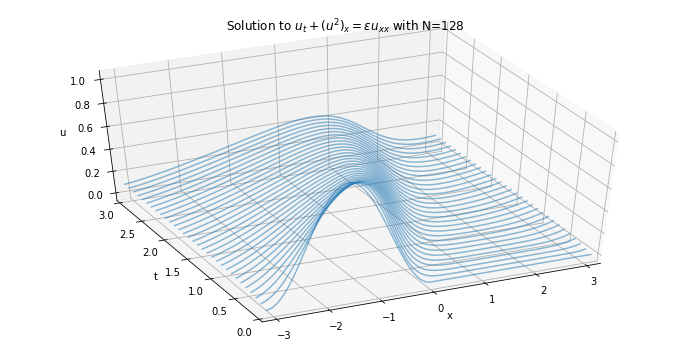

In [7]:
xgrid2,time_grid2,U2 = burgers_equation_solver(128, 0.25)
lines_plot(xgrid2, time_grid2, U2, 
           xlim=(-np.pi, np.pi), tlim=(0,3), 
           ulim=(U2.min()-0.05,U2.max()+0.05),
          title='Solution to $u_t + (u^2)_x = \epsilon u_{xx}$ with N=128')

#### Solution for `N=256`


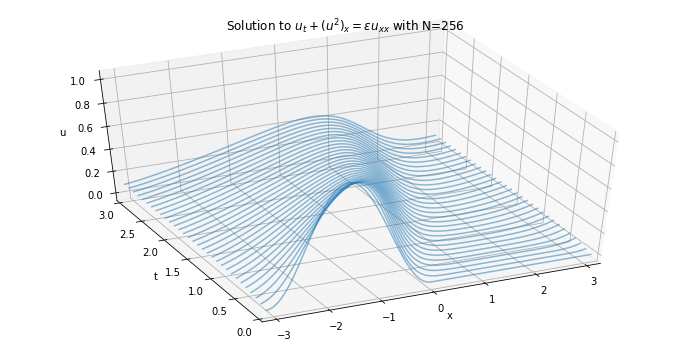

In [8]:
xgrid3,time_grid3,U3 = burgers_equation_solver(256, 0.25)
lines_plot(xgrid3, time_grid3, U3, 
           xlim=(-np.pi, np.pi), tlim=(0,3), 
           ulim=(U3.min()-0.05,U3.max()+0.05),
          title='Solution to $u_t + (u^2)_x = \epsilon u_{xx}$ with N=256')

#### Varying $\epsilon$ to the unphysical oscillations limit

In [9]:
def _helper(eps):
    xgrid,time_grid,U = burgers_equation_solver(256, eps)
    lines_plot(xgrid, time_grid, U, 
               xlim=(-np.pi, np.pi), tlim=(0,3), 
               ulim=(U3.min()-0.05,U3.max()+0.05),
              title='Solution to $u_t + (u^2)_x = \epsilon u_{xx}$ with N=256')

In [14]:
interact(_helper, eps=FloatSlider(min=0.01, max=0.25, step=0.01, value=0.25));

interactive(children=(FloatSlider(value=0.25, description=u'eps', max=0.25, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

#### References for question `#3`
* Spectral Methods in Matlab, Lloyd N. Trefethen, Chapter 10, Program 27

***
***
***

### Problem `#4`

In this problem we are encouraged to study numerically the operator $K$ defined by the following integro-differential equation:

$$
K u = -u''(x) + 4 \pi^2 \int_{0}^1 u(s)ds  \ \ \ \ \ \ \ \text{with} \ \ u(0)=u(1)=0.
$$

***

#### `part a)`

To build a numerical approximation of the $K$ operator, we need to build numerical approximations for the differential and integral parts.

where $\widetilde{D}_{N}$ is the Chebyshev differentiation matrix. 


For the integral term is a little more complicated. First of all, we will re-writte the integral in a more convinient way, using the following property:

$$
\int_a^b f(x) dx = \int_{-1}^{1} \underbrace{f\left( \frac{(b-a)t +a+b}{2} \right)}_{g(t)} \frac{b-a}{2} dt = \frac{b-a}{2} \int_{-1}^{1} g(t) dt,
$$

then, we can writte the integral term as:

$$
4\pi^2 \int_{0}^{1} u(s) ds = 4 \pi^2 \int_{-1}^{1} u\left(\frac{s+1}{2} \right) \frac{ds}{2} = 2 \pi^2 \int_{-1}^{1} \underbrace{u\left(\frac{s+1}{2} \right)}_{g(s)} ds,
$$

and then, we can approximate this numerically with the Clenshaw-Curtis quadrature:

$$
2 \pi^2 \int_{-1}^{1} g(s) ds \approx 2 \pi^2 \sum_{i=0}^N w_i g(x_i) = 2 \pi^2 \sum_{i=0}^N  w_i u\left( \frac{x_i+1}{2} \right),
$$

where $x_i$ are the quadrature nodes (Chebyshev points) and $w_i$ the quadrature weights.




Since we are interested in $u$ over $x \in [0,1]$, we need to do some arrangements to compute the differential part. If we define $x = (\epsilon+1)/2$ with $\epsilon \in [-1,1]$, then

$$
\frac{d}{dx} u(x) = \frac{d}{dx} u\left( \frac{\epsilon+1}{2} \right) = \frac{d}{d\epsilon} u\left( \frac{\epsilon+1}{2} \right)  \frac{d\epsilon}{dx} = 2 \frac{d}{d\epsilon} \underbrace{u\left( \frac{\epsilon+1}{2} \right)}_{g(\epsilon)}.
$$


Let's call $v$ to the vector obtained obtained when we evaluate $u\left( \frac{x_i+1}{2} \right)$ with $x_i$ as the Chebyshev points. Also let's call $w$ to the vector of weights of the quadrature and $W$ to the matrix whose rows are the vectors $w$. Since the integral term doesn't depend on $x$, we can write the numerical approximation as:

$$
K u \approx -4 \widetilde{D}_{N}^{2} \ v + 2 \pi^2 W_N \ v = (-4 \widetilde{D}_{N}^{2} + 2 \pi^2 W_N) \ v
$$

So, the numerical approximation of $K \approx -4 \widetilde{D}_{N}^{2} + 2 \pi^2 W_N$, where $\widetilde{D}_{N}^{2}$ is the Chebyshev differentiation matrix of size $N$, and $W_N$ is the matrix of quadrature weights of size $N$. 

***

#### `part b)`

The codes of the two cells below build the numerical approximation of the operator $K$ as described above.

In [73]:
def clencurt(N):
    """
    Code obtained from:
    https://github.com/mikaem/spmpython/blob/master/clencurt.py
    """
    theta = np.pi*np.arange(0,N+1)/N
    x = np.cos(theta)
    w = np.zeros(N+1)
    ii = np.arange(1,N)
    v = np.ones(N-1)
    if N%2==0:
        w[0] = 1./(N**2-1)
        w[N] = w[0]
        for k in np.arange(1,int(N/2.)):
            v = v-2*np.cos(2*k*theta[ii])/(4*k**2-1)
        v = v - np.cos(N*theta[ii])/(N**2-1)
    else:
        w[0] = 1./N**2
        w[N] = w[0]
        for k in np.arange(1,int((N-1)/2.)+1):
            v = v-2*np.cos(2*k*theta[ii])/(4*k**2-1)
    w[ii] = 2.0*v/N
    return x, w

In [84]:
def K_approx(N):
    """
    Numerical approximation to the operator K
    """
    D,x = cheb(N+1); D2 = np.dot(D,D)
    D2 = D2[1:-1,1:-1]
    _,w = clencurt(N+1)
    w = w[1:-1]
    return -4*D2 + (2*np.pi**2)*w

Now we build a numerical approximation of $K$ of size $32$ and compute its eigenvalues and eigenvectors.

In [89]:
K = K_approx(32)
w,v = np.linalg.eig(K)